In [1]:
# Core utilities + data handling
import os
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
from io import BytesIO
import ast
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from IPython.display import display

# Downloading / I/O
import requests
import gdown

# Models / embeddings
import clip
import torch
import torch.nn as nn
from torchvision import transforms

# Image preprocessing for visualization/model input
size_ = 512
resize = transforms.Resize(size_)
center_crop = transforms.CenterCrop(size_)

# Use GPU if available, otherwise fall back to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load Data

In [2]:
# Download the dataset from the following link (skip if you already have the dataset):
file_id = '1KJot5VeUSCUg11IuDYqmlS024MTqhUnQ'
url = f'https://drive.google.com/uc?id={file_id}'

output = 'Visual-Interestingness-Decoded-Dataset.zip'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1KJot5VeUSCUg11IuDYqmlS024MTqhUnQ
To: /home/abdu/workingDirectory/ICCV2025Git/Visual-Interestingness-Decoded-Dataset.zip
100%|██████████| 763k/763k [00:00<00:00, 16.7MB/s]


'Visual-Interestingness-Decoded-Dataset.zip'

In [3]:
# Open the ZIP file from the in-memory buffer in read mode
with zipfile.ZipFile(output, "r") as z:
    # Extract all files from the ZIP into the current directory
    z.extractall(Path("./"))

# Recursively find all CSV files in the extracted content
csv_files = sorted(Path("./").rglob("*.csv"))

# Print how many CSV files were found
print("CSVs found:", len(csv_files))

# Print the paths of the CSV files (for inspection)
for p in csv_files:
    print(p)

CSVs found: 3
Visual-Interestingness-Decoded-Dataset/Images_Metadata.csv
Visual-Interestingness-Decoded-Dataset/Relative_Interestingness.csv
Visual-Interestingness-Decoded-Dataset/Single_Interestingness.csv


In [4]:
df_images = pd.read_csv(csv_files[0])
df_relative_int = pd.read_csv(csv_files[1])
df_single_int = pd.read_csv(csv_files[2])

In [5]:
df_images.head()

,ImageID,ImageURL,ImageDescription,CuPL_Score,CI_Score,Memorability_Score,Aesthetic_Score,Num_Views,Num_Favorites,Num_Comments
0,5620359,https://c4.staticflickr.com/1/6/5620359_f4010d...,A person wearing a gas mask is standing by a w...,0.051496,0.313124,0.830520,0.531907,8354.0,4.0,0.0
1,9142920,https://c1.staticflickr.com/1/7/9142920_5587cc...,The image shows a person walking on a bridge i...,0.088578,0.427054,0.793944,0.645713,283.0,0.0,0.0
2,13541424,https://c4.staticflickr.com/1/9/13541424_0d61d...,"The image shows a large statue of a serene, ro...",0.054629,0.494198,0.829453,0.416582,1162.0,1.0,1.0
3,26597779,https://c1.staticflickr.com/1/22/26597779_d505...,A waiter in traditional attire is serving food...,0.021285,0.127285,0.783517,0.314706,6763.0,0.0,0.0
4,41972814,https://c7.staticflickr.com/1/25/41972814_68ab...,The image shows two thatched-roof huts on a gr...,0.049260,0.295821,0.678636,0.560285,576.0,0.0,0.0


#### Example Image

In [6]:
# Select a specific image and retrieve its metadata
test_ID = 51654698266
row = df_images[df_images["ImageID"] == test_ID].iloc[0]

print("Image Description:", row.ImageDescription)

# Download and load the image from its URL
response = requests.get(row.ImageURL)
url_img = Image.open(BytesIO(response.content)).convert("RGB")

Image Description: The image shows a picturesque sunset over a body of water, with trees silhouetted against the colorful sky.


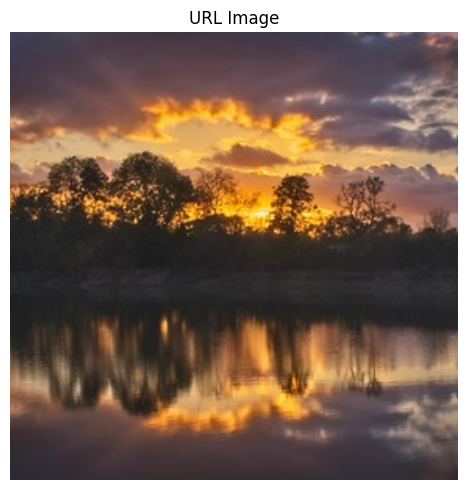

In [7]:
# Display image
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.imshow(center_crop(resize(url_img)))
axs.set_title('URL Image')
axs.axis('off')
plt.tight_layout()
plt.show()

#### Single Image Interestingness

In [8]:
# Select the row corresponding to the given ImageID
row = df_single_int[df_single_int["ImageID"] == test_ID]

# Utility to ensure values are proper Python lists
# (handles Series, already-parsed lists, and stringified lists)
def to_list(x):
    if isinstance(x, pd.Series):
        x = x.iloc[0]
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        return ast.literal_eval(x)
    return [x]

# Pretty-print paired answers and explanations for one source
def pretty_print(name, answers, explanations):
    answers = to_list(answers)
    explanations = to_list(explanations)

    print(f"\n{name}:")
    for a, e in zip(answers, explanations):
        print(f"  {a} - '{e}'")

# Display annotations for different annotators / models
pretty_print("Human", row["Human_Answers"], row["Human_Explanations"])
pretty_print("GPT-4o", row["GPT_Answers"], row["GPT_Explanations"])
pretty_print("DeepSeek-VL2", row["DeepSeek_Answers"], row["DeepSeek_Explanations"])
pretty_print("Llama 3.2", row["Llama_Answers"], row["Llama_Explanations"])



Human:
  yes - 'it is very natural'
  yes - 'i liked sunset'
  yes - 'yes its good'
  yes - 'NATURES ARE GODS GIFT FOR US SO WITH OUT THIS WE CANT LIVE  WE SAVE NATURE'
  yes - 'good'

GPT-4o:
  yes - ' the vibrant colors and serene reflection create a visually appealing scene.'
  yes - 'the vibrant sunset and serene reflection on the water create a captivating visual.'
  yes - 'the vibrant sunset colors and their reflection in the water create a captivating scene.'
  yes - ' it captures a vibrant sunset reflecting on a serene body of water.'
  yes - ' The vibrant sunset and its reflection in the water create a visually captivating scene.'

DeepSeek-VL2:
  yes - 'The image displays a serene sunset over water with reflections of trees visible in the calm surface, creating an aesthetically pleasing scene.'
  yes - 'The image shows a serene sunset over water with reflections of trees and clouds, creating a visually appealing scene.'
  yes - 'The image captures a serene sunset reflecting 

#### Relative Image Interestingness

In [9]:
# Compute a majority decision ("first" or "second") from a list of answers
def majority_vote(answers):
    answers = to_list(answers)          # Ensure input is a proper list
    if len(answers) == 0:
        return None

    # Count how often each answer occurs
    counts = Counter(answers)

    # Ignore any labels other than "first" and "second"
    counts = {k: v for k, v in counts.items() if k in ["first", "second"]}
    if len(counts) == 0:
        return None

    # Return the label with the highest count
    most_common = Counter(counts).most_common()
    return most_common[0][0]

In [10]:
# Select all relative-annotation rows where the test image appears (as ImageID1 or ImageID2)
rows = df_relative_int[
    (df_relative_int["ImageID1"] == test_ID) | 
    (df_relative_int["ImageID2"] == test_ID)
]

# Attach image URLs for both images in each pair
rows = (
    rows
    .merge(
        df_images[["ImageID", "ImageURL"]],
        left_on="ImageID1",
        right_on="ImageID",
        how="left"
    )
    .rename(columns={"ImageURL": "ImageURL1"})
    .drop(columns=["ImageID"])
)

rows = (
    rows
    .merge(
        df_images[["ImageID", "ImageURL"]],
        left_on="ImageID2",
        right_on="ImageID",
        how="left"
    )
    .rename(columns={"ImageURL": "ImageURL2"})
    .drop(columns=["ImageID"])
)

# Compute majority preference ("first" / "second") for humans and GPT
rows["Human_Majority"] = rows["Human_Answers"].apply(majority_vote)
rows["GPT_Majority"]   = rows["GPT_Answers"].apply(majority_vote)

Image 1:
Human Majority: first
GPT Majority: second

Image 2:
Human Majority: first
GPT Majority: second

Image 3:
Human Majority: first
GPT Majority: first

Image 4:
Human Majority: first
GPT Majority: first

Image 5:
Human Majority: first
GPT Majority: second



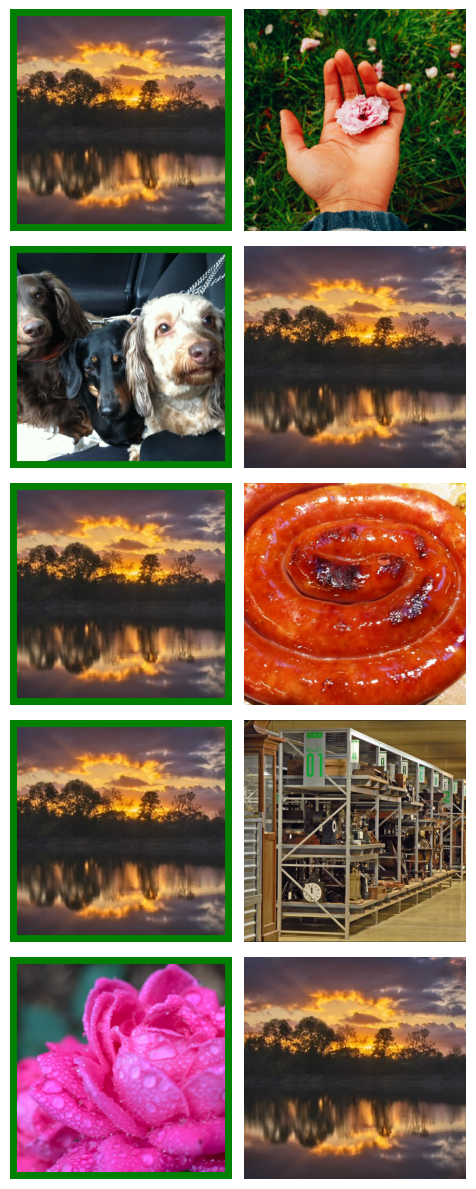

In [11]:
# Create a grid of subplots to show image pairs
fig, ax = plt.subplots(5, 2, figsize=(5, 12))

for i in range(len(rows)):
    # Load, resize, and center-crop both images in the pair
    img1 = center_crop(resize(Image.open(BytesIO(requests.get(rows.iloc[i]["ImageURL1"]).content))))
    img2 = center_crop(resize(Image.open(BytesIO(requests.get(rows.iloc[i]["ImageURL2"]).content))))

    # Display the image pair
    ax[i, 0].imshow(img1, cmap="gray")
    ax[i, 0].axis("off")
    ax[i, 1].imshow(img2, cmap="gray")
    ax[i, 1].axis("off")

    # Highlight the image preferred by the human majority
    if rows.iloc[i]["Human_Majority"] == "first":
        rect = mpatches.Rectangle((0, 0), size_, size_, linewidth=10,
                                  edgecolor="g", facecolor="none")
        ax[i, 0].add_patch(rect)
    elif rows.iloc[i]["Human_Majority"] == "second":
        rect = mpatches.Rectangle((0, 0), size_, size_, linewidth=10,
                                  edgecolor="g", facecolor="none")
        ax[i, 1].add_patch(rect)

    # Print majority decisions for this image pair
    print(
        f"Image {i+1}:\n"
        f"Human Majority: {rows.iloc[i]['Human_Majority']}\n"
        f"GPT Majority: {rows.iloc[i]['GPT_Majority']}\n"
    )

# Adjust layout and render the figure
plt.tight_layout()
plt.show()


#### Computational Model (Relative Interestingness)

In [12]:
# Load the CLIP ViT-L/14 model and its preprocessing pipeline
clip_model, preprocess = clip.load("ViT-L/14", device=device)

# Define the network for predicting relative interestingness
class BaseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BaseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)  # single-score output

    def forward(self, x):
        return self.fc1(x)

# Initialize the model, load pretrained weights, and set it to evaluation mode
RI_model = BaseNetwork(input_dim=768).to(device)
RI_model.load_state_dict(torch.load("RI_model.pth"))
RI_model.eval()

BaseNetwork(
  (fc1): Linear(in_features=768, out_features=1, bias=True)
)

In [13]:
# Collect all image URLs from both columns and remove duplicates
image_urls = rows["ImageURL1"].tolist() + rows["ImageURL2"].tolist()
image_urls = list(set(image_urls))

# Download, resize, and center-crop all unique images
images = [
    center_crop(
        resize(Image.open(BytesIO(requests.get(url).content)).convert("RGB"))
    )
    for url in image_urls
]

# Extract CLIP image embeddings
image_embeddings = []
with torch.no_grad():
    for img in images:
        img_input = preprocess(img).unsqueeze(0).to(device)
        embedding = clip_model.encode_image(img_input)
        image_embeddings.append(embedding.cpu())

# Predict relative-interestingness scores for each image
ri_scores = []
with torch.no_grad():
    for emb in image_embeddings:
        emb = emb.to(device).float()
        score = RI_model(emb).item()
        ri_scores.append(score)

# Create lookup tables from image URLs to scores and loaded images
url_to_ri_score = {url: score for url, score in zip(image_urls, ri_scores)}
url_to_image = {url: img for url, img in zip(image_urls, images)}


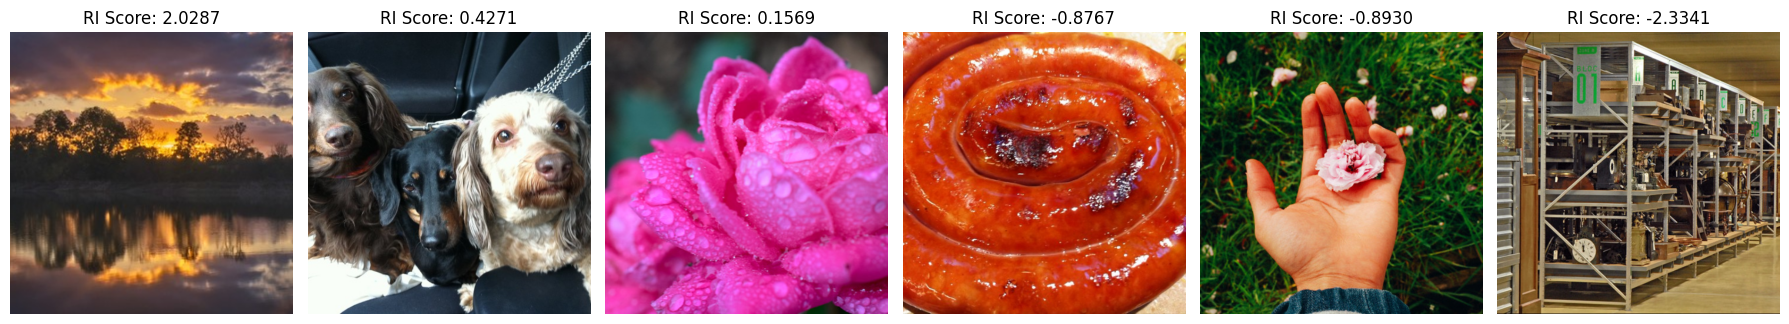

In [14]:
# Sort images by predicted RI score (highest first)
sorted_images = sorted(
    url_to_ri_score.items(), key=lambda x: x[1], reverse=True
)

# Visualize the top-6 most interesting images
fig, axs = plt.subplots(1, 6, figsize=(18, 5))
for i in range(6):
    url, score = sorted_images[i]
    img = url_to_image[url]

    axs[i].imshow(img)
    axs[i].set_title(f"RI Score: {score:.4f}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()
